In [1]:
import pandas as pd
import ast
import numpy as np
from functools import partial
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras
import random
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-09-30 18:04:48.954182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Function to load and preprocess the data

In [2]:
def load_data(window_size):
    if window_size==50:
        csv_file="data/avg_padded_truncated_mfcc_50ms.csv"
    elif window_size==100:
        csv_file="data/avg_padded_truncated_mfcc_100ms.csv"
    else:
        csv_file="data/avg_padded_truncated_mfcc_500ms.csv"
    data = pd.read_csv(csv_file)
    num_mfccs = int(data['num_mfcc_values'][0])
    mfcc_columns = [f'mfcc_{i}' for i in range(1, 14)]
    X = np.array([data[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns])
    # Reshape X to (number of instances, num_mfccs, 13, 1)
    X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
    X = X.reshape(-1, num_mfccs, 13, 1)
    y = data['label']
    return num_mfccs,X,y

In [3]:
def split_data(no_class, X,y):
    if no_class==2: # binary classification
        label_mapping = {'N': 0, 'S1': 1, 'S2':1, 'S3':1}
    else: 
        label_mapping = {'N': 0, 'S1': 1, 'S2':2, 'S3':3}
    y= y.replace(label_mapping)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val= train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val 

## Function to create and fit CNN model

In [4]:
def create_fit_cnn(X_train, X_val, num_mfccs, no_class):
    
    if no_class==2: # binary classification
        units=1 # no of neurons in output layer
        activation='sigmoid' #sigmoid activation for binary classification
        loss='binary_crossentropy'
    else: 
        units=4
        activation='softmax' #Softmax activation for 4 class
        loss='sparse_categorical_crossentropy'
        
    DefaultConv2D = partial(layers.Conv2D, kernel_size=3, activation="relu", padding='same')
    cnn_model = models.Sequential([
        DefaultConv2D(filters=32, kernel_size=3, input_shape=(num_mfccs, 13, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),

        DefaultConv2D(filters=64),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dense(units=128, activation="relu", kernel_initializer="lecun_normal"),
        layers.BatchNormalization(),

        layers.Dense(units=units, activation=activation)
    ])
    optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    # Compile the model with the given learning rate schedule
    cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_cb=keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    history = cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, lr_scheduler_cb])
    return cnn_model, history

## Function to plot learning curve

In [5]:
#function to plot accuracy, loss and learning rate
def plot_loss_accuracy(history):
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot Accuracy Curve
    axes[0].plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plot Loss Curve
    axes[1].plot(history.history['loss'], 'r-', label='Training Loss')
    axes[1].plot(history.history['val_loss'], 'b-', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Curve")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")

    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the combined plot
    plt.show()

## Function to print confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_conf_matrix(y_train, y_train_pred, y_test, y_test_pred, class_names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=class_names).im_.colorbar.remove()
    axs[0].set_title("Train set ")
    axs[0].tick_params(axis='x', labelrotation=90)
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=class_names).im_.colorbar.remove()
    axs[1].set_title("Test set ")
    axs[1].tick_params(axis='x', labelrotation=90)
    plt.show()

# Multiclass Classification
### Window size: 50 ms

In [8]:
num_mfccs, X, y = load_data(50)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(4,X,y)
cnn_4_50, history_4_50 = create_fit_cnn(X_train, X_val, num_mfccs, 4)

Epoch 1/50
768/768 [==============================] - 30s 38ms/step - loss: 0.2242 - accuracy: 0.9257 - val_loss: 0.2293 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 36s 46ms/step - loss: 0.1689 - accuracy: 0.9420 - val_loss: 0.1373 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 40s 53ms/step - loss: 0.1490 - accuracy: 0.9481 - val_loss: 0.1275 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 44s 58ms/step - loss: 0.1351 - accuracy: 0.9517 - val_loss: 0.1355 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 47s 61ms/step - loss: 0.1250 - accuracy: 0.9554 - val_loss: 0.1346 - val_accuracy: 0.9526 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 50s 65ms/step - loss: 0.1204 - accuracy: 0.9565 - val_loss: 0.2142 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 51s 

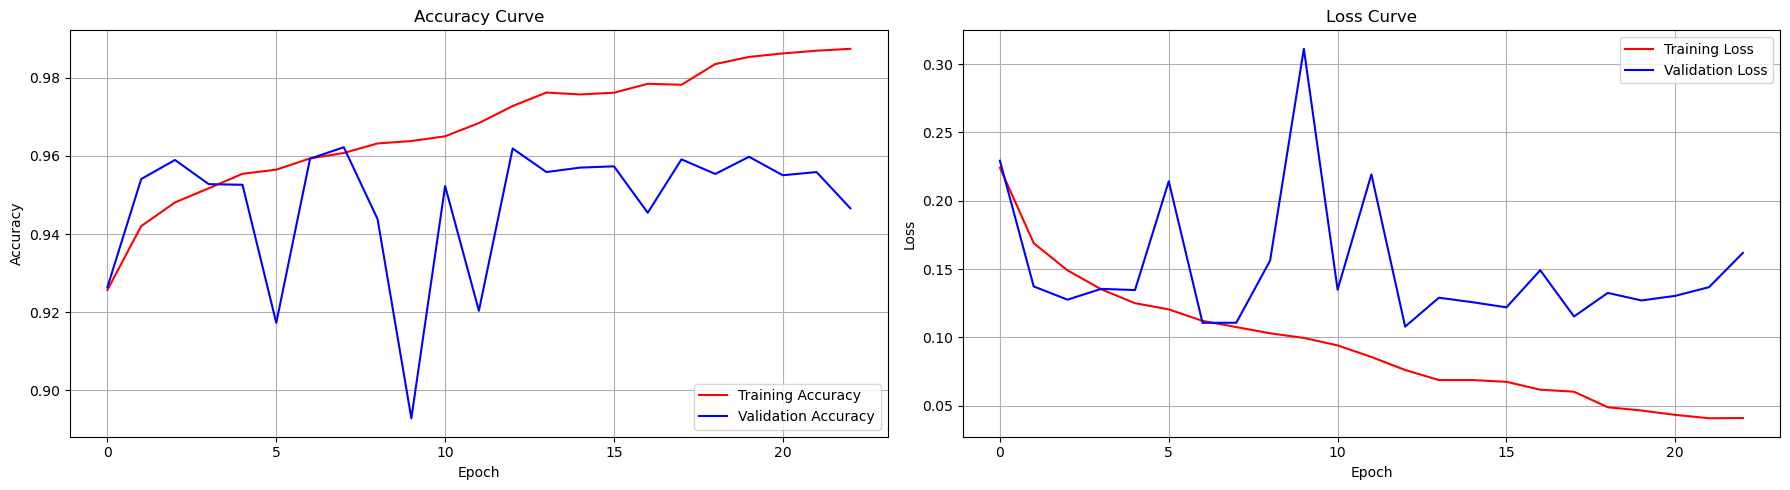

In [9]:
plot_loss_accuracy(history_4_50)

In [10]:
y_train_pred_4_50 = cnn_4_50.predict(X_train)
y_train_pred_4_50 = y_train_pred_4_50.argmax(axis=-1)

y_test_pred_4_50 = cnn_4_50.predict(X_test)
y_test_pred_4_50 = y_test_pred_4_50.argmax(axis=-1)

240/240 [==============================] - 7s 28ms/step


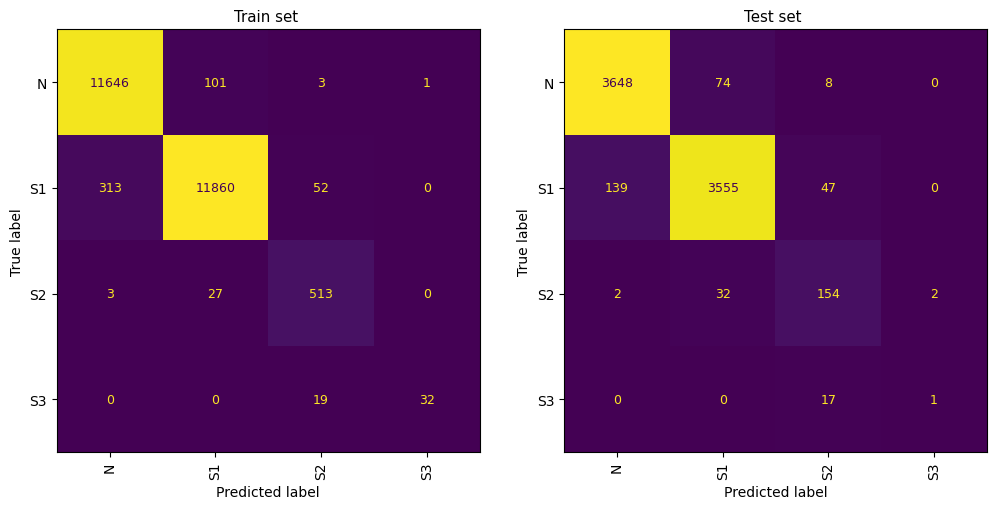

In [11]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_4_50, y_test, y_test_pred_4_50, class_names)

## Window Size: 100 ms

In [12]:
num_mfccs, X, y = load_data(100)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(4,X,y)
cnn_4_100, history_4_100 = create_fit_cnn(X_train, X_val, num_mfccs, 4)

Epoch 1/50
768/768 [==============================] - 43s 55ms/step - loss: 0.2314 - accuracy: 0.9216 - val_loss: 0.1963 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 41s 53ms/step - loss: 0.1744 - accuracy: 0.9401 - val_loss: 0.1331 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 40s 52ms/step - loss: 0.1488 - accuracy: 0.9475 - val_loss: 0.4025 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 38s 50ms/step - loss: 0.1337 - accuracy: 0.9523 - val_loss: 0.1121 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 39s 51ms/step - loss: 0.1290 - accuracy: 0.9542 - val_loss: 0.1187 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 41s 53ms/step - loss: 0.1223 - accuracy: 0.9552 - val_loss: 0.1269 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 39s 

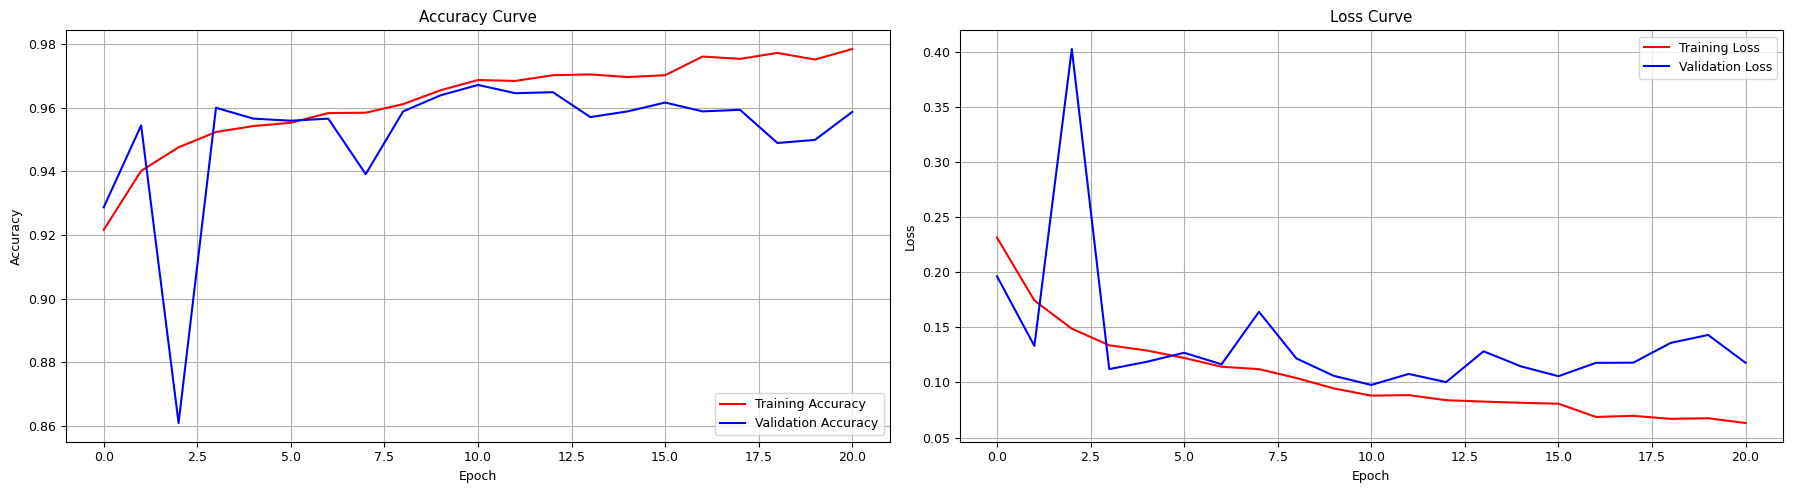

In [13]:
plot_loss_accuracy(history_4_100)

In [14]:
y_train_pred_4_100 = cnn_4_100.predict(X_train)
y_train_pred_4_100 = y_train_pred_4_100.argmax(axis=-1)

y_test_pred_4_100 = cnn_4_100.predict(X_test)
y_test_pred_4_100 = y_test_pred_4_100.argmax(axis=-1)

240/240 [==============================] - 4s 16ms/step


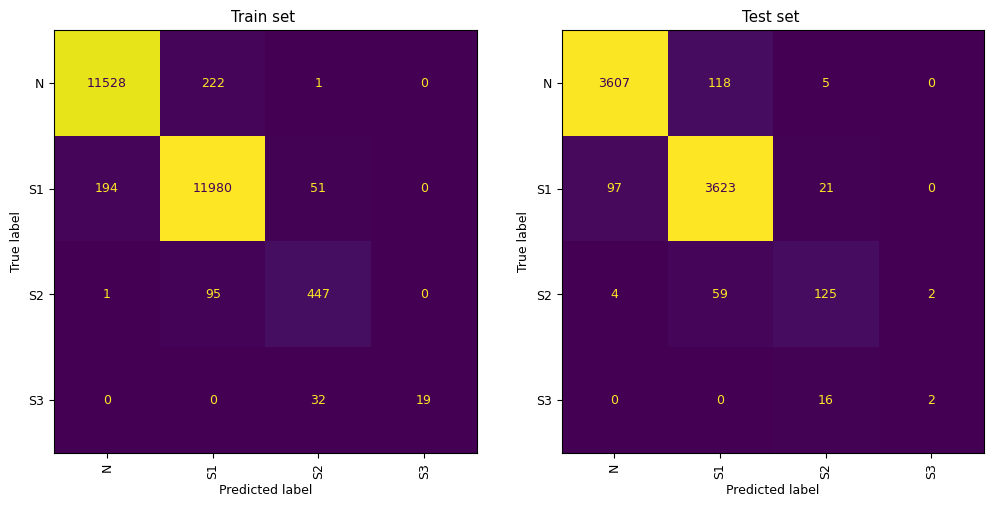

In [15]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_4_100, y_test, y_test_pred_4_100, class_names)

## Window Size:500

In [16]:
num_mfccs, X, y = load_data(500)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(4,X,y)
cnn_4_500, history_5_100 = create_fit_cnn(X_train, X_val, num_mfccs, 4)

Epoch 1/50
768/768 [==============================] - 10s 12ms/step - loss: 0.2586 - accuracy: 0.9169 - val_loss: 0.2124 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 9s 12ms/step - loss: 0.1866 - accuracy: 0.9354 - val_loss: 0.1490 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 10s 13ms/step - loss: 0.1685 - accuracy: 0.9425 - val_loss: 0.1553 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 10s 13ms/step - loss: 0.1578 - accuracy: 0.9431 - val_loss: 0.1405 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 10s 13ms/step - loss: 0.1466 - accuracy: 0.9494 - val_loss: 0.2858 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 10s 13ms/step - loss: 0.1430 - accuracy: 0.9483 - val_loss: 0.1885 - val_accuracy: 0.9305 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 11s 1

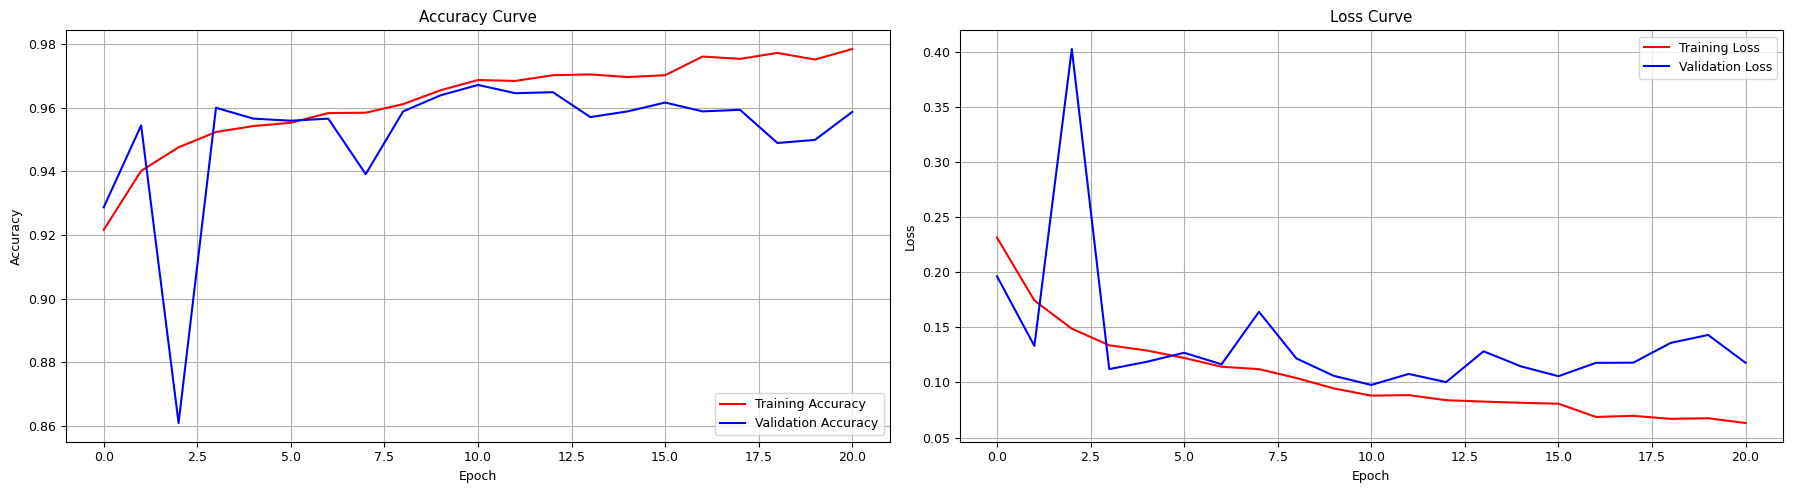

In [17]:
plot_loss_accuracy(history_4_100)

In [18]:
y_train_pred_4_500 = cnn_4_500.predict(X_train)
y_train_pred_4_500 = y_train_pred_4_500.argmax(axis=-1)

y_test_pred_4_500 = cnn_4_500.predict(X_test)
y_test_pred_4_500 = y_test_pred_4_500.argmax(axis=-1)

240/240 [==============================] - 1s 4ms/step


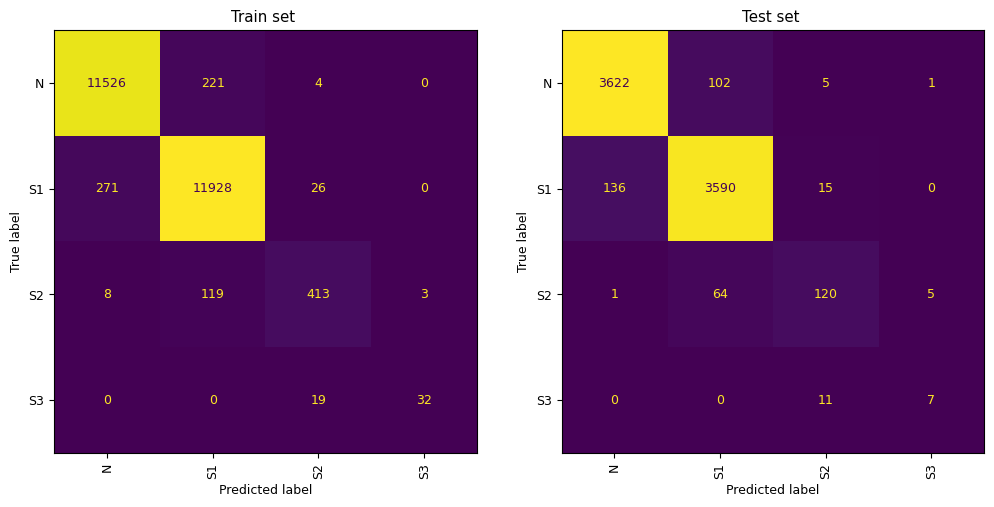

In [19]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_4_500, y_test, y_test_pred_4_500, class_names)

## Binary Classification

### Window size: 50

In [20]:
num_mfccs, X, y = load_data(50)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(2,X,y)
cnn_2_50, history_2_50 = create_fit_cnn(X_train, X_val, num_mfccs, 2)

Epoch 1/50
768/768 [==============================] - 47s 61ms/step - loss: 0.1298 - accuracy: 0.9459 - val_loss: 0.1014 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 48s 63ms/step - loss: 0.1054 - accuracy: 0.9593 - val_loss: 0.1679 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 47s 62ms/step - loss: 0.0972 - accuracy: 0.9629 - val_loss: 0.0868 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 44s 57ms/step - loss: 0.0923 - accuracy: 0.9656 - val_loss: 0.1007 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 47s 61ms/step - loss: 0.0889 - accuracy: 0.9670 - val_loss: 0.1279 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 45s 58ms/step - loss: 0.0836 - accuracy: 0.9697 - val_loss: 0.0862 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 46s 

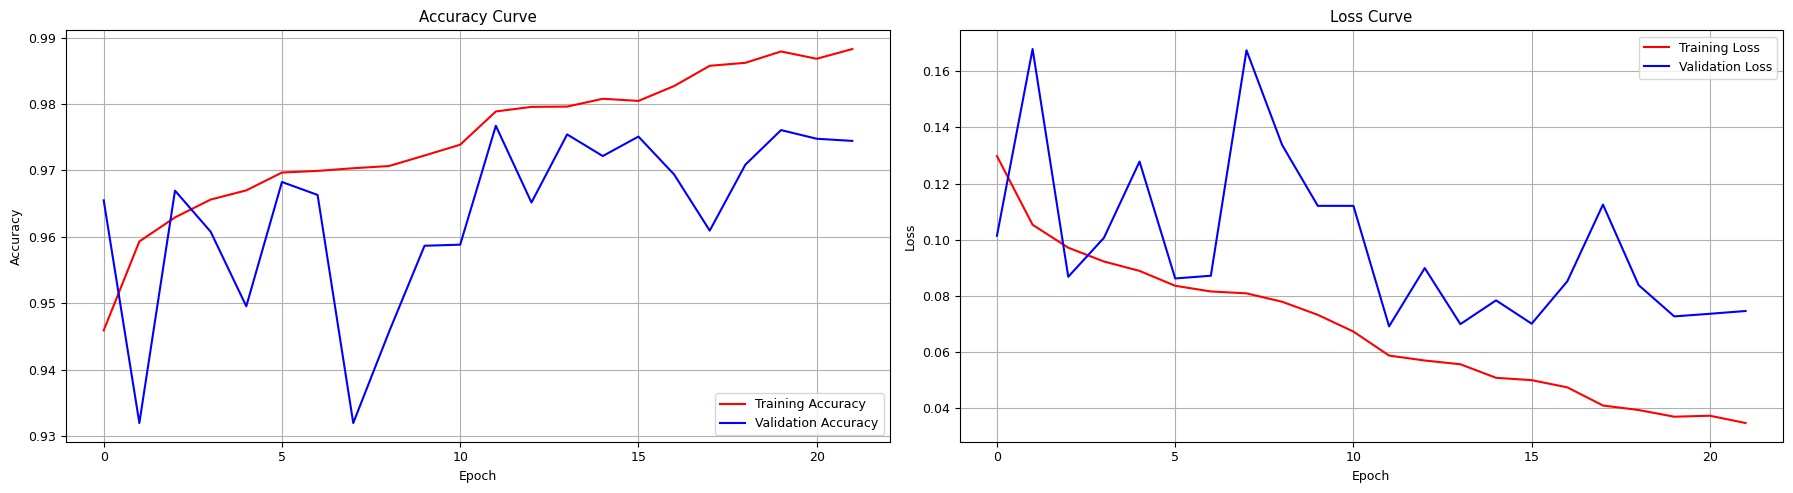

In [21]:
plot_loss_accuracy(history_2_50)

In [22]:
y_train_pred_2_50 = cnn_2_50.predict(X_train)
y_test_pred_2_50 = cnn_2_50.predict(X_test)
y_train_pred_2_50 = (y_train_pred_2_50 >= 0.5).astype(int)
y_test_pred_2_50 = (y_test_pred_2_50 >= 0.5).astype(int)

240/240 [==============================] - 5s 21ms/step


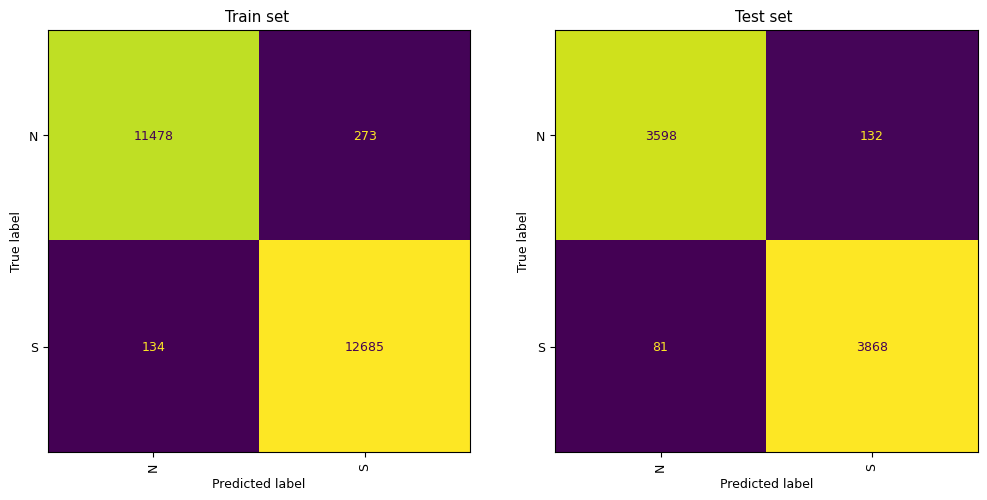

In [23]:
class_names=['N','S']
print_conf_matrix(y_train, y_train_pred_2_50, y_test, y_test_pred_2_50, class_names)

### Window size: 100

In [24]:
num_mfccs, X, y = load_data(100)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(2,X,y)
cnn_2_100, history_2_100 = create_fit_cnn(X_train, X_val, num_mfccs, 2)

Epoch 1/50
768/768 [==============================] - 32s 41ms/step - loss: 0.1338 - accuracy: 0.9450 - val_loss: 0.0976 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 35s 46ms/step - loss: 0.1044 - accuracy: 0.9600 - val_loss: 0.1073 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 31s 41ms/step - loss: 0.0968 - accuracy: 0.9631 - val_loss: 0.1462 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 31s 40ms/step - loss: 0.0943 - accuracy: 0.9649 - val_loss: 0.1624 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 33s 43ms/step - loss: 0.0863 - accuracy: 0.9670 - val_loss: 0.0788 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 30s 39ms/step - loss: 0.0838 - accuracy: 0.9683 - val_loss: 0.1049 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 29s 

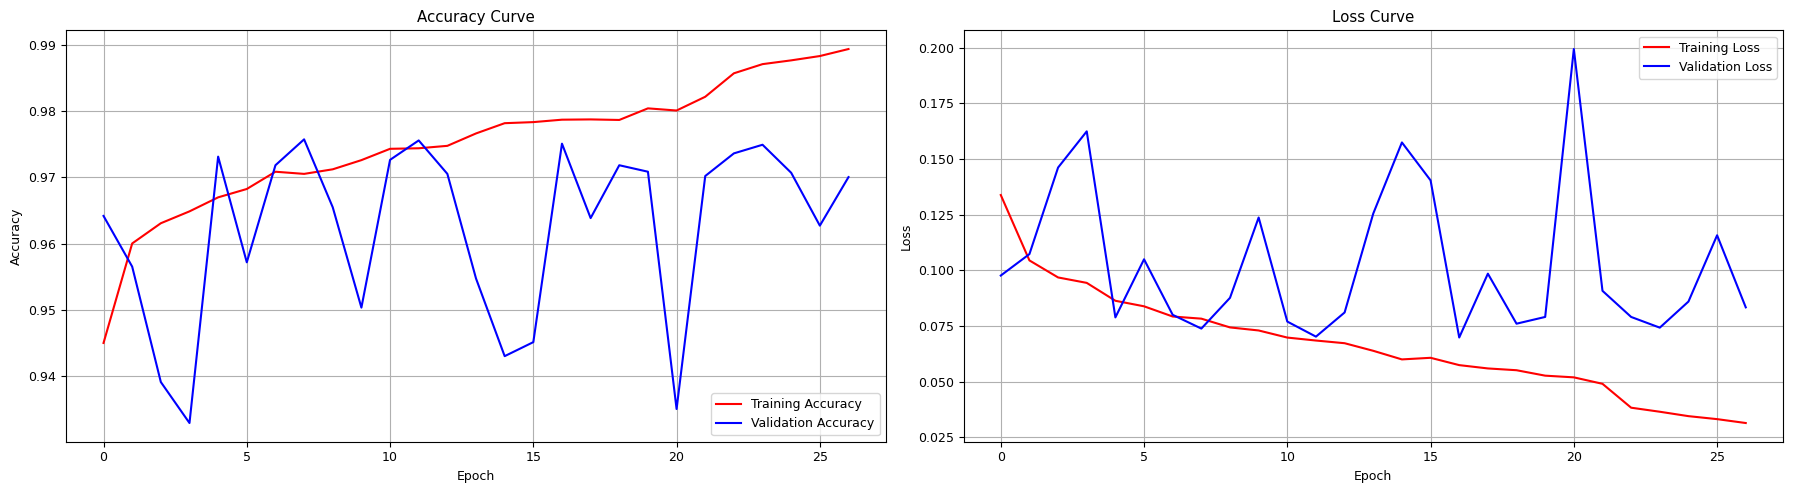

In [25]:
plot_loss_accuracy(history_2_100)

In [26]:
y_train_pred_2_100 = cnn_2_100.predict(X_train)
y_test_pred_2_100 = cnn_2_100.predict(X_test)
y_train_pred_2_100 = (y_train_pred_2_100 >= 0.5).astype(int)
y_test_pred_2_100 = (y_test_pred_2_100 >= 0.5).astype(int)

240/240 [==============================] - 4s 15ms/step


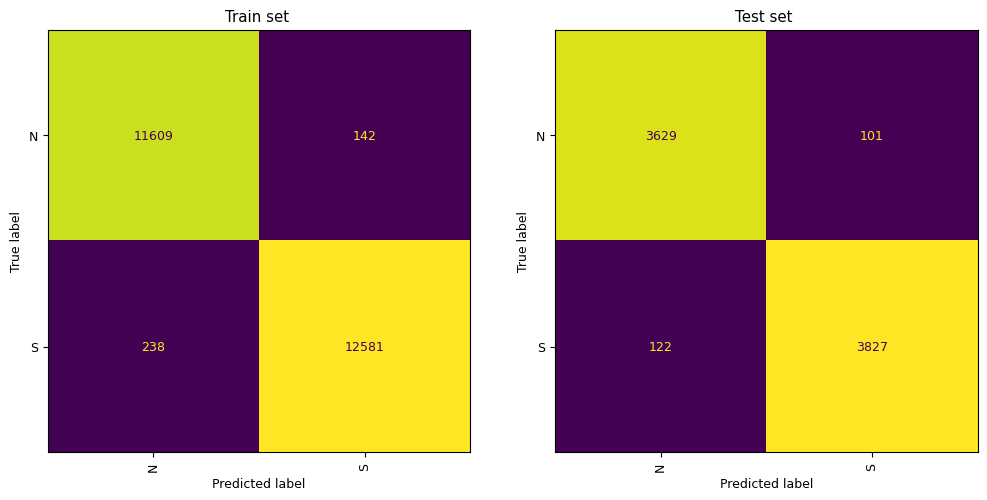

In [27]:
print_conf_matrix(y_train, y_train_pred_2_100, y_test, y_test_pred_2_100, class_names)

### Window size: 500

In [28]:
num_mfccs, X, y = load_data(500)
X_train, X_test, X_val, y_train, y_test, y_val = split_data(2,X,y)
cnn_2_500, history_2_500 = create_fit_cnn(X_train, X_val, num_mfccs, 2)

Epoch 1/50
768/768 [==============================] - 11s 13ms/step - loss: 0.1525 - accuracy: 0.9395 - val_loss: 0.1213 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 2/50
768/768 [==============================] - 9s 12ms/step - loss: 0.1242 - accuracy: 0.9549 - val_loss: 0.1023 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 3/50
768/768 [==============================] - 9s 12ms/step - loss: 0.1129 - accuracy: 0.9583 - val_loss: 0.1518 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 4/50
768/768 [==============================] - 10s 13ms/step - loss: 0.1092 - accuracy: 0.9588 - val_loss: 0.0988 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 5/50
768/768 [==============================] - 8s 11ms/step - loss: 0.1010 - accuracy: 0.9641 - val_loss: 0.0936 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 6/50
768/768 [==============================] - 9s 11ms/step - loss: 0.1018 - accuracy: 0.9630 - val_loss: 0.0964 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 7/50
768/768 [==============================] - 9s 12ms/

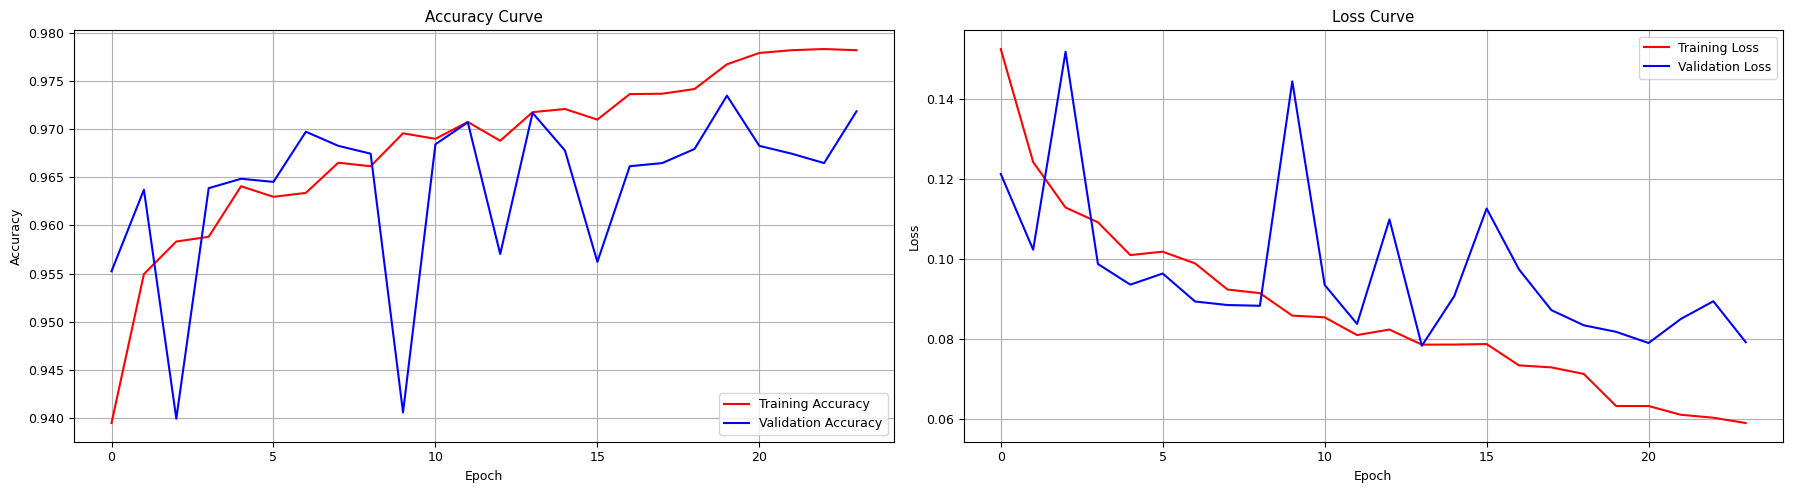

In [29]:
plot_loss_accuracy(history_2_500)

In [30]:
y_train_pred_2_500 = cnn_2_500.predict(X_train)

y_test_pred_2_500 = cnn_2_500.predict(X_test)
y_train_pred_2_500 = (y_train_pred_2_500 >= 0.5).astype(int)
y_test_pred_2_500 = (y_test_pred_2_500 >= 0.5).astype(int)

240/240 [==============================] - 1s 3ms/step


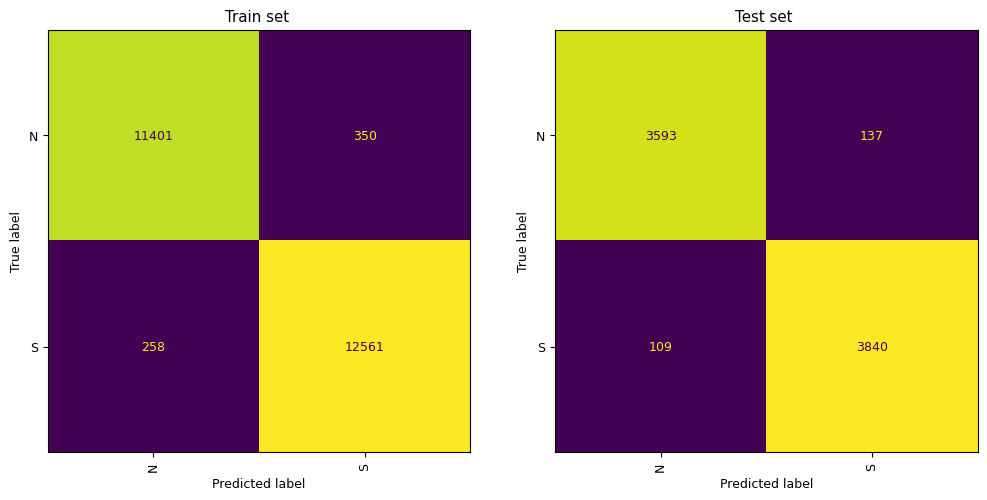

In [31]:
print_conf_matrix(y_train, y_train_pred_2_500, y_test, y_test_pred_2_500, class_names)

In [32]:
from sklearn.metrics import accuracy_score, f1_score
def cal_scores (y_true, y_pred):
    return  f1_score(y_true,y_pred, average="macro"), accuracy_score(y_true,y_pred)

In [33]:
train_f1_cnn_4_50, train_accuracy_cnn_4_50 = cal_scores(y_train, y_train_pred_4_50)
test_f1_cnn_4_50, test_accuracy_cnn_4_50 = cal_scores(y_test, y_test_pred_4_50)

In [34]:
train_f1_cnn_4_100, train_accuracy_cnn_4_100 = cal_scores(y_train, y_train_pred_4_100)
test_f1_cnn_4_100, test_accuracy_cnn_4_100 = cal_scores(y_test, y_test_pred_4_100)

In [35]:
train_f1_cnn_4_500, train_accuracy_cnn_4_500 = cal_scores(y_train, y_train_pred_4_500)
test_f1_cnn_4_500, test_accuracy_cnn_4_500 = cal_scores(y_test, y_test_pred_4_500)

In [45]:
print("F1 Score and Accuracy for multiclass")
cnn_metrics = {
    "Data Set": ["Accuracy-50ms", "F1 Score-50ms","Accuracy-100ms", "F1 Score-100ms","Accuracy-500ms", "F1 Score-500ms"],
    "Training Set": [f"{train_accuracy_cnn_4_50:.2%}", f"{train_f1_cnn_4_50:.2%}", f"{train_accuracy_cnn_4_100:.2%}", f"{train_f1_cnn_4_100:.2%}", f"{train_accuracy_cnn_4_500:.2%}", f"{train_f1_cnn_4_500:.2%}"],
    "Test Set": [f"{test_accuracy_cnn_4_50:.2%}", f"{test_f1_cnn_4_50:.2%}",f"{test_accuracy_cnn_4_100:.2%}", f"{test_f1_cnn_4_100:.2%}",f"{test_accuracy_cnn_4_500:.2%}", f"{test_f1_cnn_4_500:.2%}"]}
cnn_metrics_df = pd.DataFrame(cnn_metrics)
cnn_metrics_df

F1 Score and Accuracy for multiclass


,Data Set,Training Set,Test Set
0,Accuracy-50ms,95.78%,94.22%
1,F1 Score-50ms,48.52%,47.83%
2,Accuracy-100ms,96.06%,94.92%
3,F1 Score-100ms,48.59%,48.01%
4,Accuracy-500ms,95.94%,94.75%
5,F1 Score-500ms,48.48%,47.89%


In [36]:
train_f1_cnn_2_50, train_accuracy_cnn_2_50 = cal_scores(y_train, y_train_pred_2_50)
test_f1_cnn_2_50, test_accuracy_cnn_2_50 = cal_scores(y_test, y_test_pred_2_50)
train_f1_cnn_2_100, train_accuracy_cnn_2_100 = cal_scores(y_train, y_train_pred_2_100)
test_f1_cnn_2_100, test_accuracy_cnn_2_100 = cal_scores(y_test, y_test_pred_2_100)
train_f1_cnn_2_500, train_accuracy_cnn_2_500 = cal_scores(y_train, y_train_pred_2_500)
test_f1_cnn_2_500, test_accuracy_cnn_2_500 = cal_scores(y_test, y_test_pred_2_500)

In [47]:
print("F1 Score and Accuracy for binary Classification")
cnn_metrics_binary = {
    "Data Set": ["Accuracy-50ms", "F1 Score-50ms","Accuracy-100ms", "F1 Score-100ms","Accuracy-500ms", "F1 Score-500ms"],
    "Training Set": [f"{train_accuracy_cnn_2_50:.2%}", f"{tr[ain_f1_cnn_2_50:.2%}", f"{train_accuracy_cnn_2_100:.2%}", f"{train_f1_cnn_2_100:.2%}", f"{train_accuracy_cnn_2_500:.2%}", f"{train_f1_cnn_2_500:.2%}"],
    "Test Set": [f"{test_accuracy_cnn_2_50:.2%}", f"{test_f1_cnn_2_50:.2%}",f"{test_accuracy_cnn_2_100:.2%}", f"{test_f1_cnn_2_100:.2%}",f"{test_accuracy_cnn_2_500:.2%}", f"{test_f1_cnn_2_500:.2%}"]}
cnn_metrics_binary_df = pd.DataFrame(cnn_metrics_binary)
cnn_metrics_binary_df

F1 Score and Accuracy for binary Classification


,Data Set,Training Set,Test Set
0,Accuracy-50ms,98.34%,97.23%
1,F1 Score-50ms,98.34%,97.22%
2,Accuracy-100ms,98.45%,97.10%
3,F1 Score-100ms,98.45%,97.09%
4,Accuracy-500ms,97.53%,96.80%
5,F1 Score-500ms,97.52%,96.79%
